# Raster CNN Visualization

In [16]:
from link_bot_models.raster_cnn_model import RasterCNNModel
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model
from link_bot_pycommon import link_bot_pycommon
np.set_printoptions(suppress=True, linewidth=220)
plt.style.use("slides")
plt.style.use("slides")

In [17]:
filename = "./log_data/raster_cnn_big/June_19_20-15-00__3723805536/nn.07.hdf5"
args_dict = {
    'checkpoint': filename,
}
model = RasterCNNModel.load(args_dict, [100, 100], 6)

Restored keras model ./log_data/raster_cnn_big/June_19_20-15-00__3723805536/nn.07.hdf5


In [18]:
k = model.keras_model
ws = k.get_weights()
for w in ws:
    print(w.shape)

(5, 5, 4, 32)
(32,)
(5, 5, 32, 32)
(32,)
(3, 3, 32, 16)
(16,)
(3, 3, 16, 16)
(16,)
(256, 256)
(256,)
(256, 256)
(256,)
(256, 1)
(1,)


In [19]:
len(ws)
wmap = {
    'conv1': 0,
    'conv1_bias': 1,
    'conv2': 2,
    'conv2_bias': 3,
    'conv3': 4,
    'conv3_bias': 5,
    'conv4': 6,
    'conv4_bias': 7,
    'f1': 8,
    'f1_bias': 9,
    'f2': 10,
    'f2_bias': 11,
    'f3': 12,
    'f3_bias': 13,
}

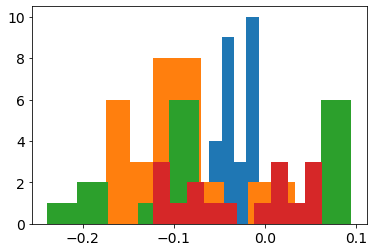

In [20]:
plt.hist(ws[wmap['conv1_bias']])
plt.hist(ws[wmap['conv2_bias']])
plt.hist(ws[wmap['conv3_bias']])
plt.hist(ws[wmap['conv4_bias']]);

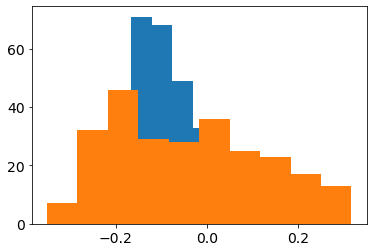

In [21]:
plt.hist(ws[wmap['f1_bias']])
plt.hist(ws[wmap['f2_bias']]);
# plt.hist(ws[wmap['f3_bias']]);

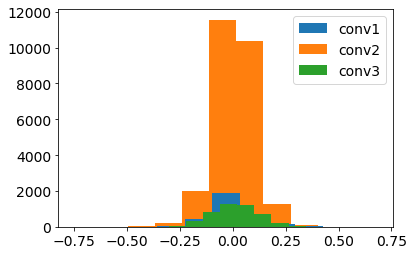

In [22]:
plt.hist(ws[wmap['conv1']].flatten(), label='conv1', zorder=1);
plt.hist(ws[wmap['conv2']].flatten(), label='conv2', zorder=0);
plt.hist(ws[wmap['conv3']].flatten(), label='conv3', zorder=2);
plt.legend();

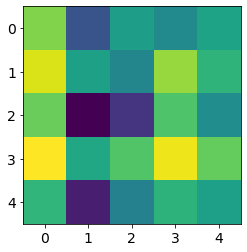

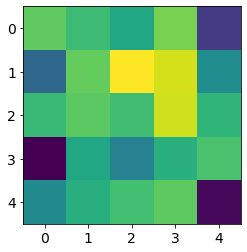

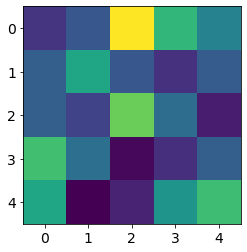

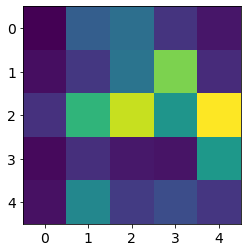

In [23]:
for i in range(4):
    plt.figure()
    plt.imshow(ws[wmap['conv1']][:, :, i, 0])

In [24]:
no_fc_model = Model(inputs=model.keras_model.inputs, outputs=model.keras_model.layers[-4].output)

In [25]:
def prediction(rope_configuration):
    # predict
    sdf_data = link_bot_pycommon.SDF.load("./data/train_1_10/sdf_data_0.npz")
    rope_images = link_bot_pycommon.make_rope_images(sdf_data, rope_configuration)
    x = {
        'sdf': sdf_data.sdf[np.newaxis, :, :, np.newaxis],
        'rope_image': rope_images,
    }
    y = no_fc_model.predict(x)
    
    return y, sdf_data
    
def viz(sdf_data, rope_configuration):
    # viz
    plt.figure()
    plt.title("histogram of latent vector")
    plt.hist(y.flatten());

    plt.figure()
    plt.title("Scene")
    plt.imshow(sdf_data.image, extent=sdf_data.extent);
    plt.plot([rope_configuration[0], rope_configuration[2], rope_configuration[4]],
             [rope_configuration[1], rope_configuration[3], rope_configuration[5]], c='w')
    plt.scatter(rope_configuration[4], rope_configuration[5], c='r', zorder=3)


In [26]:
for head_x in np.arange(0.6, 1.9, 0.05):
    rope_configuration = link_bot_pycommon.make_rope_configuration(head_x, -0.3, 2.5, 1.5)
    if np.allclose(head_x, 1.5):
        print("==================")
    y, sdf_data = prediction(rope_configuration)
    print(y.mean())
# viz(sdf_data, rope_configuration)

-2.2881827
-2.2942214
-2.2403643
-2.202896
-2.186053
-2.196268
-2.185882
-2.1532583
-2.0864134
-2.0254917
-1.9566567
-1.8151846
-1.7847931
-1.8109173
-1.7810502
-1.7037916
-1.659621
-1.7113295
-1.7109559
-1.4942433
-1.5295522
-1.6877726
-1.7218459
-1.8434043
-1.8550496
-1.9547008


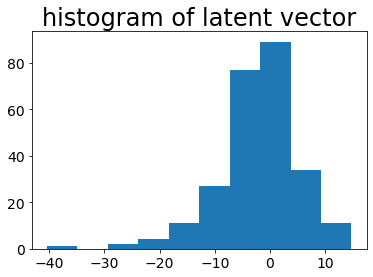

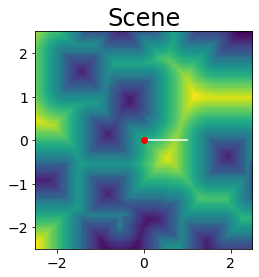

In [27]:
rope_configuration = link_bot_pycommon.make_rope_configuration(0, 0, 0, 0)
y, sdf_data = prediction(rope_configuration)
viz(sdf_data, rope_configuration)

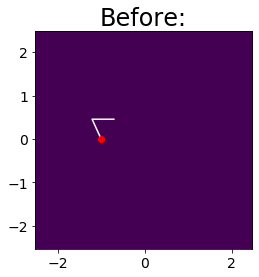

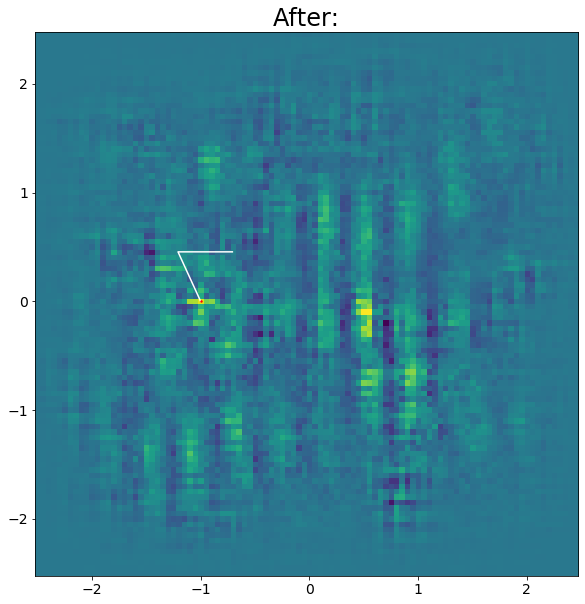

In [28]:
loss = K.mean(model.keras_model.layers[-1].output)
grads = K.gradients(loss, model.keras_model.inputs[0])
grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)

iterate = K.function(model.keras_model.inputs,[loss,grads])

step = 0.05

sdf_data = link_bot_pycommon.SDF.load("./data/train_1_10/sdf_data_0.npz")
rope_configuration = link_bot_pycommon.make_rope_configuration(-1.0, 0, 2, 0)
rope_images = link_bot_pycommon.make_rope_images(sdf_data, rope_configuration)
x = {
    'sdf': sdf_data.sdf[np.newaxis, :, :, np.newaxis],
    'rope_image': rope_images,
}

Z_in = x['sdf']
Z_in = np.zeros_like(x['sdf'])
Z_adapt = Z_in.copy()

while True:
    loss_val, grads_val = iterate([Z_adapt, rope_images])
    clipped_grad = np.clip(grads_val[0], -1, 1)
    Z_adapt -= clipped_grad * step
    m = np.sum(grads_val)
    if abs(m) < 0.01:
        break
        
extent = sdf_data.extent - np.array([sdf_data.resolution[0]/2, sdf_data.resolution[0]/2, sdf_data.resolution[0]/2, sdf_data.resolution[0]/2])

plt.figure()
plt.title("Before:")
plt.imshow(np.flipud(Z_in.squeeze().T), extent=extent)
plt.plot([rope_configuration[0], rope_configuration[2], rope_configuration[4]],
         [rope_configuration[1], rope_configuration[3], rope_configuration[5]], c='w')
plt.scatter(rope_configuration[4], rope_configuration[5], c='r', zorder=3)

plt.figure(figsize=(10,10))
plt.title("After:")
plt.imshow(np.flipud(Z_adapt.squeeze().T), extent=extent)
plt.plot([rope_configuration[0], rope_configuration[2], rope_configuration[4]],
         [rope_configuration[1], rope_configuration[3], rope_configuration[5]], c='w')
plt.scatter(rope_configuration[4], rope_configuration[5], c='r', zorder=3, s=2)
None;

In [29]:
keras.utils.plot_model(model.keras_model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')